# Train Extreme Loss First
This algorithm doesn't randomize X for training. It actually does a forward pass and calculates loss, then it sorts the data in reverse order of loss. This way batches that train first are of the highest loss.
This repeats every epoch

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader

## functions that we are trying to approximate

In [78]:
np.random.seed(10)

# y = ax^4 + bx^3 + cx^2 + dx + f
def f_quartic(x):
    a = -0.0179516
    b = 0.331323
    c = -1.63398
    d = 1.01107
    f = 5.73434
    return a*x**4 + b*x**3 + c*x**2 + d*x + f

def f_semicircle(x):
    maxX = np.max(x)
    minX = np.min(x)
    radius = (maxX - minX)/2 
    center = (maxX + minX)/2 
    return np.sqrt(radius**2 - (center-x)**2)

def frand(f, x):
    y = f(x)
    return y + y*np.random.uniform(-0.1, 0.1, x.shape).astype('f')

(1250,)

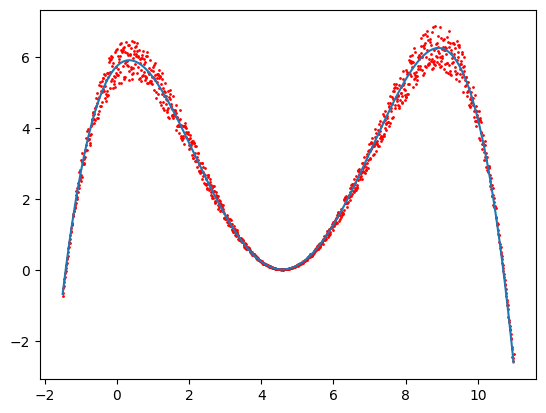

In [84]:
# show data for function 
f = f_quartic

xs = np.arange(-1.5, 11, .01)
ys = f(xs)
yrand = frand(f, xs)
plt.scatter(xs, yrand, color='red',s=1)
plt.plot(xs, ys)
xs.shape

## Define Data Loaders (InfiniteRandom and ExtremeLossFirst)

In [385]:
from torch.utils.data.dataloader import DataLoader

class InfiniteRandomDataLoader:

    def __init__(self, dataset, loss, **kwargs):
        train_sampler = torch.utils.data.RandomSampler(dataset, replacement=True, num_samples=int(1e10))
        self.train_loader = DataLoader(dataset, sampler=train_sampler, **kwargs)
        self.data_iter = iter(self.train_loader)

    def next(self):
        try:
            batch = next(self.data_iter)
        except StopIteration: # this will technically only happen after 1e10 samples... (i.e. basically never)
            self.data_iter = iter(self.train_loader)
            batch = next(self.data_iter)
        return batch


In [367]:
""" ExtremeLossFirstDataloader:
    init should be called in every epoc (ie when we exhaust all samples).
    in init() we find out loss and order data in reverse order of loss
    next() fetches batches of data in order of sorting.
"""
class ExtremeLossFirstDataloader:

    def __init__(self, dataset, loss, **kwargs):
        # sort dataset based on the loss
        sortedloss, indices = torch.sort(allloss,dim=-2,descending=True) #reverse sort loss
        sorted_dataset = torch.index_select(x, 0, torch.reshape(indices,(indices.shape[0],)))
        self.train_loader = DataLoader(sorted_dataset, **kwargs)
        self.data_iter = iter(self.train_loader)

    def next(self):
        try:
            batch = next(self.data_iter)
        except StopIteration: # this will technically only happen after 1e10 samples... (i.e. basically never)
            self.data_iter = iter(self.train_loader)
            batch = next(self.data_iter)
        return batch

In [505]:
""" TopNLossFirstDataloader:
    init should be called in every epoc (ie when we exhaust all samples).
    in init() we find out loss and order data in reverse order of loss, we use only top 20% of the data with most loss.
    next() fetches batches of data in order of sorting.
"""
class TopNLossFirstDataloader:

    def __init__(self, dataset, loss, **kwargs):
        # sort dataset based on the loss
        sortedloss, indices = torch.sort(allloss,dim=-2,descending=True) #reverse sort loss
        sorted_dataset = torch.index_select(x, 0, torch.reshape(indices,(indices.shape[0],)))
        topNpct = 64 #int(sorted_dataset.shape[0]*.2)
        train_sampler = torch.utils.data.RandomSampler(sorted_dataset[0:topNpct], replacement=True, num_samples=int(1e10))
        self.train_loader = DataLoader(dataset, sampler=train_sampler, **kwargs)
        self.data_iter = iter(self.train_loader)
        
    def next(self):
        try:
            batch = next(self.data_iter)
        except StopIteration: # this will technically only happen after 1e10 samples... (i.e. basically never)
            self.data_iter = iter(self.train_loader)
            batch = next(self.data_iter)
        return batch

### test ExtremeLossForstDataLoader

In [452]:
#test
x = torch.tensor(xs.reshape(xs.shape[0],1), dtype=torch.float32)
yact = frand(f, x)

# Forward pass
with torch.no_grad():
    ypred = newmodel(x)
    lossfn = nn.MSELoss(reduction = 'none')
    allloss = lossfn(ypred, yact)

In [453]:
#Testing the ExtrmeLossFirstDataLoader
#xtest = np.arange(allloss.shape[0])
dataLoader = TopNLossFirstDataloader
batch_loader = dataLoader(x, allloss, batch_size=64, pin_memory=True, num_workers=1)

In [ ]:
batch_loader.next()

## Define the neural network model

In [82]:
class TwoHiddenLayerNet(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
        super(TwoHiddenLayerNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.fc3 = nn.Linear(hidden2_size, output_size)

    def forward(self, x):
        # x = F.relu(self.fc1(x))
        x = F.leaky_relu(self.fc1(x), negative_slope=0.1)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.1)
        x = self.fc3(x)
        return x

## Model Training with random data loader

### init training

In [421]:
# init training
import time
from torch.optim.lr_scheduler import ReduceLROnPlateau

torch.manual_seed(10)
newmodel = TwoHiddenLayerNet(1, 4, 2, 1)
dataLoader = InfiniteRandomDataLoader

# init optimizer
criterion = nn.MSELoss()
x = torch.tensor(xs.reshape(xs.shape[0],1), dtype=torch.float32)

best_loss = 0.1
step = 0
losses = np.array([])

### Training loop

step 19100 | loss 0.4418 | step time 0.42ms
step 19200 | loss 0.4404 | step time 0.45ms
step 19300 | loss 0.4390 | step time 0.41ms
step 19400 | loss 0.4377 | step time 0.43ms
step 19500 | loss 0.4363 | step time 0.44ms
step 19600 | loss 0.4350 | step time 0.42ms
step 19700 | loss 0.4337 | step time 0.41ms
step 19800 | loss 0.4324 | step time 0.41ms
step 19900 | loss 0.4311 | step time 0.41ms
step 20000 | loss 0.4298 | step time 0.43ms


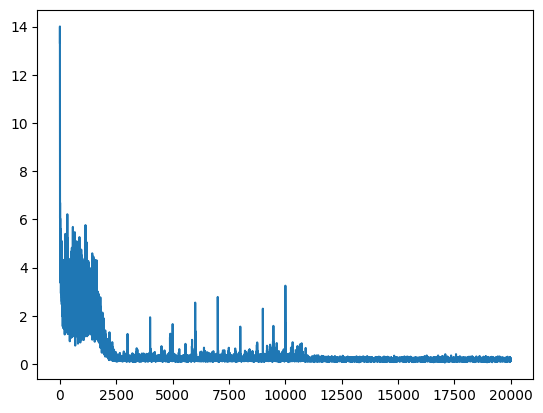

In [185]:
# training loop

lr=0.001
max_steps = 1000

optimizer = torch.optim.AdamW(newmodel.parameters(), lr=lr, betas=(0.9, 0.99), eps=1e-8)
# init dataloader
batch_loader = dataLoader(x, batch_size=64, pin_memory=True, num_workers=1)

while True:

    t0 = time.time()
    # get the next batch, ship to device, and unpack it to input and target
    X = batch_loader.next()
    Y = frand(f, X)

    # Forward pass
    ypred = newmodel(X)

    # Calculate the loss
    loss = criterion(ypred, Y)
    losses = np.append(losses, loss.item())

    # Backward and optimize
    newmodel.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    # wait for 
    t1 = time.time()

    step += 1
    last100loss = losses.mean()
    if losses.shape[0] > 100:
        last100loss = losses[:-100].mean()
            
    # logging
    if step % 100 == 0:         
        print(f"step {step} | loss {last100loss:.4f} | step time {(t1-t0)*1000:.2f}ms")

    # termination conditions
    if max_steps >= 0 and step % max_steps == 0:
        break
        
    if last100loss < best_loss:
        break

# plot loss
plt.plot(losses)

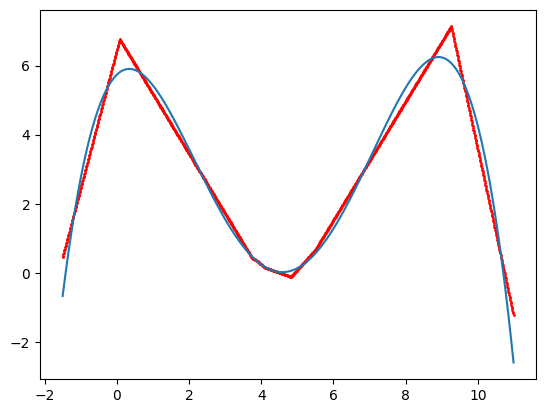

In [186]:
# plot trained model
y = newmodel(x)
yexact = f(xs)
yout = y.data.reshape(xs.shape[0])
plt.plot(xs, yexact)
plt.scatter(xs, yout, color='red', s=1)

# Display the plot
plt.show()

## Model Training with ExtremeLossFirst Method

### init training

In [537]:
# init training
import time
from torch.optim.lr_scheduler import ReduceLROnPlateau

torch.manual_seed(10)
newmodel = TwoHiddenLayerNet(1, 4, 2, 1)
# dataLoader = ExtremeLossFirstDataloader
# dataLoader = InfiniteRandomDataLoader
dataLoader = TopNLossFirstDataloader

# init optimizer
criterion = nn.MSELoss(reduction = 'mean')
x = torch.tensor(xs.reshape(xs.shape[0],1), dtype=torch.float32)
yact = frand(f, x)

best_loss = 0.1
step = 0
losses = np.array([])

### training loop

In [538]:
# training loop

lr=0.1
batch_size = 64
max_steps = 1  #### int(x.shape[0]/batch_size) #selected as our data is only 1250/64
optimizer = torch.optim.AdamW(newmodel.parameters(), lr=lr, betas=(0.9, 0.99), eps=1e-8)

# init dataloader
# Forward pass
with torch.no_grad():
    ypred = newmodel(x)
    lossfn = nn.MSELoss(reduction = 'none')
    loss_before = lossfn(ypred, yact)
    batch_loader = dataLoader(x, loss_before, batch_size=batch_size, pin_memory=True, num_workers=1)

while True:

    t0 = time.time()
    # get the next batch, ship to device, and unpack it to input and target
    X = batch_loader.next()
    Y = frand(f, X)

    # Forward pass
    ypred = newmodel(X)

    # Calculate the loss
    loss = criterion(ypred, Y)
    loss_after = lossfn(ypred, Y)
    losses = np.append(losses, loss.item())
    print("mean = " , loss.item())
    for i in range(batch_size):
        print (f"x={X[i].item():.2f} Y={Y[i].item():.2f} loss_after={loss_after[i].item():.2f}")
    
    # Backward and optimize
    newmodel.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    # wait for 
    t1 = time.time()

    step += 1
    last100loss = losses.mean()
    if losses.shape[0] > 100:
        last100loss = losses[:-100].mean()
            
    # logging
    if step % 100 == 0:         
        print(f"step {step} | loss {last100loss:.4f} | step time {(t1-t0)*1000:.2f}ms")

    # termination conditions
    if max_steps >= 0 and step % max_steps == 0:
        break
        
    if last100loss < best_loss:
        break

batch_x = 

mean =  3.9087579250335693
x=-0.90 Y=3.40 allloss=12.10
x=-1.33 Y=0.64 allloss=0.51
x=-1.34 Y=0.62 allloss=0.48
x=-1.43 Y=-0.11 allloss=0.00
x=-0.96 Y=2.80 allloss=8.28
x=-1.31 Y=0.74 allloss=0.67
x=-1.19 Y=1.66 allloss=3.01
x=-0.90 Y=3.37 allloss=11.84
x=-0.93 Y=3.09 allloss=9.99
x=-1.07 Y=2.44 allloss=6.33
x=-0.97 Y=3.04 allloss=9.67
x=-1.43 Y=-0.10 allloss=0.00
x=-1.48 Y=-0.51 allloss=0.19
x=-1.29 Y=0.94 allloss=1.03
x=-1.28 Y=0.94 allloss=1.02
x=-0.93 Y=3.17 allloss=10.51
x=-1.25 Y=1.15 allloss=1.50
x=-1.25 Y=1.31 allloss=1.91
x=-1.26 Y=1.23 allloss=1.70
x=-1.38 Y=0.28 allloss=0.12
x=-1.25 Y=1.25 allloss=1.75
x=-1.24 Y=1.33 allloss=1.97
x=-1.15 Y=1.72 allloss=3.21
x=-1.20 Y=1.58 allloss=2.72
x=-1.17 Y=1.82 allloss=3.60
x=-1.50 Y=-0.69 allloss=0.38
x=-1.37 Y=0.37 allloss=0.20
x=-1.12 Y=2.20 allloss=5.17
x=-1.28 Y=0.95 allloss=1.05
x=-1.40 Y=0.14 allloss=0.04
x=-1.00 Y=2.52 allloss=6.74
x=-1.49 Y=-0.53 allloss=0.21
x=-1.26 Y=1.11 allloss=1.40
x=-1.06 Y=2.42 allloss=6.21
x=-1.44 Y=-0.

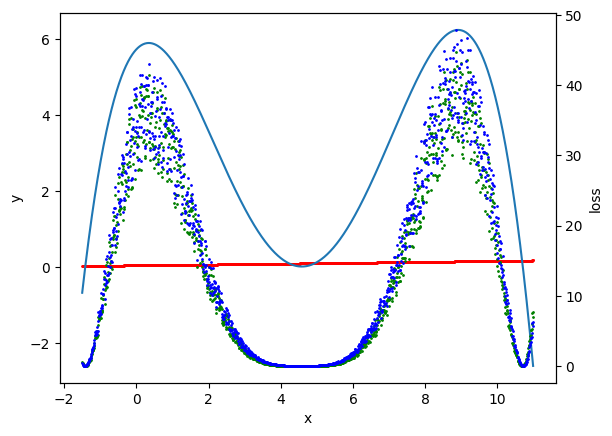

In [539]:
# plot trained model

with torch.no_grad():
    ypred = newmodel(x)
    lossfn = nn.MSELoss(reduction = 'none')
    allloss = lossfn(ypred, yact)
yout = ypred.data.reshape(xs.shape[0])

fig, ax = plt.subplots()
# Plot the data on the primary axis
ax.plot(xs, yexact)
ax.scatter(xs, yout, color='red', s=1)

# Create the secondary axis
ax2 = ax.twinx()
# Plot the data on the secondary axis
ax2.scatter(xs, allloss, color='green', s=1)
ax2.scatter(xs, loss_before, color='blue', s=1)

# Set the labels for the axes
ax.set_xlabel('x')
ax.set_ylabel('y')
ax2.set_ylabel('loss')

# Display the plot
plt.show()

In [406]:
losses[:-100].std()

3.9755540133149103

In [496]:
#test
x = torch.tensor(xs.reshape(xs.shape[0],1), dtype=torch.float32)
yact = frand(f, x)

# Forward pass
with torch.no_grad():
    ypred = newmodel(x)
    lossfn = nn.MSELoss(reduction = 'none')
    allloss = lossfn(ypred, yact)
    
sortedloss, indices = torch.sort(allloss,dim=-2,descending=True) #reverse sort loss
sorted_dataset = torch.index_select(x, 0, torch.reshape(indices,(indices.shape[0],)))

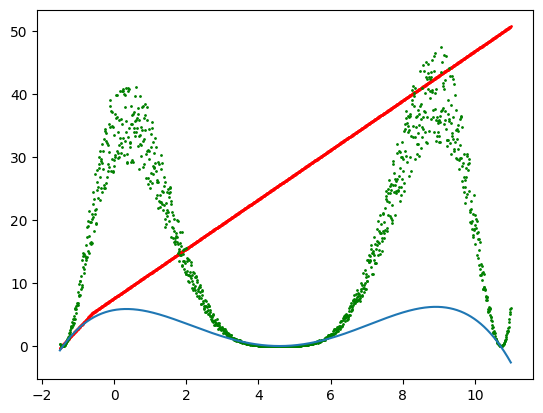

In [504]:
with torch.no_grad():
    ypred = newmodel(x)
    lossfn = nn.MSELoss(reduction = 'none')
    allloss = lossfn(ypred, yact)
    
yout = ypred.data.reshape(xs.shape[0])
plt.plot(xs, yexact)
plt.scatter(xs, yout, color='red', s=1)
plt.scatter(xs, allloss, color='green', s=1)
# Display the plot
plt.show()

In [497]:
for i in range(20):
    print (f"x={sorted_dataset[i].item():.2f} y={f(sorted_dataset[i]).item():.2f} loss={sortedloss[i].item():.2f} index={indices[i].item()}")

x=9.02 y=6.23 loss=47.21 index=1052
x=9.07 y=6.21 loss=47.12 index=1057
x=9.04 y=6.22 loss=47.09 index=1054
x=8.98 y=6.24 loss=46.82 index=1048
x=8.97 y=6.24 loss=46.00 index=1047
x=8.75 y=6.21 loss=45.77 index=1025
x=9.18 y=6.15 loss=45.45 index=1068
x=8.88 y=6.24 loss=45.38 index=1038
x=8.99 y=6.24 loss=45.29 index=1049
x=9.14 y=6.17 loss=45.16 index=1064
x=9.12 y=6.19 loss=45.14 index=1062
x=8.66 y=6.16 loss=45.11 index=1016
x=9.05 y=6.22 loss=44.99 index=1055
x=8.74 y=6.21 loss=44.85 index=1024
x=9.01 y=6.23 loss=44.72 index=1051
x=8.79 y=6.23 loss=44.40 index=1029
x=8.78 y=6.22 loss=44.06 index=1028
x=8.83 y=6.24 loss=43.85 index=1033
x=8.73 y=6.20 loss=43.62 index=1023
x=9.15 y=6.17 loss=43.42 index=1065


In [477]:
for i in range(0,20):
    print (f"x={x[i].item():.2f} y={yact[i].item():.2f} ypred={ypred[i].item():.2f} allloss={allloss[i].item():.2f}")

x=-1.50 y=-0.72 ypred=-0.63 allloss=0.01
x=-1.49 y=-0.62 ypred=-0.55 allloss=0.00
x=-1.48 y=-0.49 ypred=-0.47 allloss=0.00
x=-1.47 y=-0.42 ypred=-0.39 allloss=0.00
x=-1.46 y=-0.36 ypred=-0.32 allloss=0.00
x=-1.45 y=-0.27 ypred=-0.24 allloss=0.00
x=-1.44 y=-0.18 ypred=-0.16 allloss=0.00
x=-1.43 y=-0.09 ypred=-0.08 allloss=0.00
x=-1.42 y=-0.02 ypred=-0.01 allloss=0.00
x=-1.41 y=0.07 ypred=0.07 allloss=0.00
x=-1.40 y=0.14 ypred=0.15 allloss=0.00
x=-1.39 y=0.22 ypred=0.23 allloss=0.00
x=-1.38 y=0.29 ypred=0.30 allloss=0.00
x=-1.37 y=0.39 ypred=0.38 allloss=0.00
x=-1.36 y=0.47 ypred=0.46 allloss=0.00
x=-1.35 y=0.50 ypred=0.54 allloss=0.00
x=-1.34 y=0.56 ypred=0.61 allloss=0.00
x=-1.33 y=0.62 ypred=0.69 allloss=0.01
x=-1.32 y=0.70 ypred=0.77 allloss=0.01
x=-1.31 y=0.75 ypred=0.82 allloss=0.00
